# Augmentation analysis

## repeats lib1 overall results (all methods comparison)

In [1]:
target = "pho4_nxs_rpts_lib1"

In [2]:
import os
import re
import json
import gzip
import codecs
import math
from math import log, ceil
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import pandas as pd
import modisco.util
from collections import Counter
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
import matplotlib
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr, gaussian_kde
font = {'weight' : 'bold', 'size'   : 14}
num_samples = 100
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0,2"

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [3]:
if not os.path.exists("comparison_figs/"+target):
    os.makedirs("comparison_figs/"+target)
if not os.path.exists("comparison_figs/"+target+"/de_novo"):
    os.makedirs("comparison_figs/"+target+"/de_novo")
if not os.path.exists("comparison_figs/"+target+"/calibrated"):
    os.makedirs("comparison_figs/"+target+"/calibrated")

class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class LinearRegression(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose 

    def __call__(self, valid_preacts, valid_labels):
        lr = LR().fit(valid_preacts.reshape(-1, 1), valid_labels)
    
        def calibration_func(preact):
            return lr.predict(preact.reshape(-1, 1))

        return calibration_func

def plot_and_save(xvals, yvals, key, xlabel, ylabel, path, same_scale=False):
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    plt.figure()
    matplotlib.rc('font', **font)
    if same_scale:
        min_lim = min(np.min(xvals), np.min(yvals))
        max_lim = max(np.max(xvals), np.max(yvals))
        plt.xlim(min_lim-0.5, max_lim+0.5)
        plt.ylim(min_lim-0.5, max_lim+0.5)
        plt.gca().set_aspect('equal', adjustable='box')
    metadata = {}
    metadata["key"] = key
    metadata["x-axis"] = xlabel
    metadata["y-axis"] = ylabel
    metadata["Number of points"] = len(xvals)
    metadata["spearman"] = spearmanr(xvals, yvals)[0]
    metadata["pearson"] = pearsonr(xvals, yvals)[0]
    metadata["rmse"] = math.sqrt(mean_squared_error(xvals, yvals))
    with open(path+key+'_metadata.json', 'w') as fp: json.dump(metadata, fp)
    plt.scatter(xvals, yvals,  c=z, edgecolor='', alpha=0.9)
    if same_scale:
        x = np.linspace(min_lim-0.5, max_lim+0.5, num=len(yvals))
        b, m = polyfit(xvals, yvals, 1)
        plt.plot(x, b + m * x, color="black")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(path+key+'.png', dpi=300, format='png')
    plt.clf()

In [4]:
# reading from allddGs both seqs and vals
df1 = pd.read_csv('repeats_evaluations/library1_allddGs_normalized.csv', sep = ',')
lib1_ddGs = list(df1['Pho4_ddG_mean'])
lib1_seqs = list(df1['Sequence'])
lib1_names = list(df1['Oligo_Identity'])

seqs = []
names = []
all_xvals = []
seqToLabel = {}
for cid, seq in enumerate(lib1_seqs):
    if 'Y' in seq \
    or 'R' in seq \
    or 'K' in seq \
    or 'S' in seq: continue
    seqs.append(seq)
    names.append(lib1_names[cid])
    all_xvals.append(lib1_ddGs[cid])
    seqToLabel[seq] = lib1_ddGs[cid]

num_samples = min(1000, ceil(0.2*len(seqs)))
print(num_samples, len(seqs))
calibration_samples = np.random.choice(seqs, num_samples, replace=False)
sample_labels = []
for seq in calibration_samples:
    sample_labels.append(seqToLabel[seq])
sample_labels = np.array(sample_labels)

7 31


In [5]:
fastapath = "/users/amr1/pho4/data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

peaks_dir = "/oak/stanford/groups/akundaje/amr1/pho4_final/lite_data/in-vivo/"
seq_len = 546
out_pred_len = 200
seq_peaks = []
with gzip.open(peaks_dir+'pho4_nexus/test_1k_around_summits.bed.gz', 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        center = int((int(line.strip().split('\t')[1])+int(line.strip().split('\t')[2]))/2)
        start = center - int(seq_len/2)
        end = center + int(seq_len/2)
        candidate_seq = GenomeDict[chrm][start:end].upper()
        if len(candidate_seq) == seq_len: seq_peaks.append(candidate_seq)
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]+insert+seq[flank+len(insert):]
    return new_seq

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

indices = np.random.choice(len(seq_peaks), num_samples, replace=False) 

In [6]:
# Affinity Distill
if not os.path.exists("comparison_figs/"+target+"/de_novo/affinity_distill"):
    os.makedirs("comparison_figs/"+target+"/de_novo/affinity_distill")
if not os.path.exists("comparison_figs/"+target+"/calibrated/affinity_distill"):
    os.makedirs("comparison_figs/"+target+"/calibrated/affinity_distill")
if not os.path.exists("comparison_figs/"+target+"/de_novo/affinity_distill_augmented"):
    os.makedirs("comparison_figs/"+target+"/de_novo/affinity_distill_augmented")
if not os.path.exists("comparison_figs/"+target+"/calibrated/affinity_distill_augmented"):
    os.makedirs("comparison_figs/"+target+"/calibrated/affinity_distill_augmented")

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("/oak/stanford/groups/akundaje/amr1/pho4_final/models/example_models/pho4_nexus.h5")
seqToDeltaLogCounts = {}
for seq in seqs:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict(getOneHot(pre_seqs))
    post = model.predict(getOneHot(post_seqs))
    seqToDeltaLogCounts[seq] = np.mean(post[0]-pre[0])
del model
K.clear_session()

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("/users/amr1/pho4/repeats_evaluations/pho4_nexus/pho4_nexus.h5")
seqToDeltaLogCounts_augmented = {}
for seq in seqs:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict(getOneHot(pre_seqs))
    post = model.predict(getOneHot(post_seqs))
    seqToDeltaLogCounts_augmented[seq] = np.mean(post[0]-pre[0])
del model
K.clear_session()







Instructions for updating:
Use `tf.cast` instead.


In [7]:
yvals = []
for seq in seqs:
    yvals.append(float(seqToDeltaLogCounts[seq]))
yvals = np.array(yvals)
plot_and_save(all_xvals, yvals, "affinity_distill",
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/affinity_distill/')
yvals = []
for seq in seqs:
    yvals.append(float(seqToDeltaLogCounts_augmented[seq]))
yvals = np.array(yvals)
plot_and_save(all_xvals, yvals, "affinity_distill_augmented",
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/affinity_distill_augmented/')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
sample_preds = []
for seq in calibration_samples:
    sample_preds.append(float(seqToDeltaLogCounts[seq]))
sample_preds = np.array(sample_preds)
pre_yvals = []
for seq in seqs:
    pre_yvals.append(float(seqToDeltaLogCounts[seq]))
pre_yvals = np.array(pre_yvals)
lr1 = LinearRegression()
calibration_func1 = lr1(sample_preds, sample_labels)
yvals = calibration_func1(pre_yvals)
plot_and_save(all_xvals, yvals, "affinity_distill",
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Log Signal Intensity",
              path='comparison_figs/'+target+'/calibrated/affinity_distill/',
              same_scale=True)
residuals = all_xvals - yvals  # residuals are y - yhat
plot_and_save(yvals, residuals, "residuals",
              xlabel="Predictions",
              ylabel="Residuals",
              path='comparison_figs/'+target+'/calibrated/affinity_distill/')

sample_preds = []
for seq in calibration_samples:
    sample_preds.append(float(seqToDeltaLogCounts_augmented[seq]))
sample_preds = np.array(sample_preds)
pre_yvals = []
for seq in seqs:
    pre_yvals.append(float(seqToDeltaLogCounts_augmented[seq]))
pre_yvals = np.array(pre_yvals)
lr1 = LinearRegression()
calibration_func1 = lr1(sample_preds, sample_labels)
yvals = calibration_func1(pre_yvals)
plot_and_save(all_xvals, yvals, "affinity_distill_augmented",
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Log Signal Intensity",
              path='comparison_figs/'+target+'/calibrated/affinity_distill_augmented/',
              same_scale=True)
residuals = all_xvals - yvals  # residuals are y - yhat
plot_and_save(yvals, residuals, "residuals",
              xlabel="Predictions",
              ylabel="Residuals",
              path='comparison_figs/'+target+'/calibrated/affinity_distill_augmented/')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
# MoDISco
if not os.path.exists("comparison_figs/"+target+"/de_novo/modisco"):
    os.makedirs("comparison_figs/"+target+"/de_novo/modisco")
if not os.path.exists("comparison_figs/"+target+"/calibrated/modisco"):
    os.makedirs("comparison_figs/"+target+"/calibrated/modisco")
    
post_hypimps = np.load("/oak/stanford/groups/akundaje/amr1/pho4_final/models/imp-scores/pho4_nexus/post_counts_hypimps.npy")
post_actualimps = np.load("/oak/stanford/groups/akundaje/amr1/pho4_final/models/imp-scores/pho4_nexus/post_counts_actualimps.npy")  
modisco_seqs = np.load("/oak/stanford/groups/akundaje/amr1/pho4_final/models/imp-scores/pho4_nexus/seqs.npy")
grp = h5py.File("/oak/stanford/groups/akundaje/amr1/pho4_final/models/modisco/pho4_nexus/counts_results.hdf5","r")
print(post_actualimps.shape, post_hypimps.shape, modisco_seqs.shape)
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
            task_names=["task0_logcount"], contrib_scores={"task0_logcount": post_actualimps},
            hypothetical_contribs={"task0_logcount": post_hypimps}, one_hot=modisco_seqs)
loaded_tfmodisco_results = workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)

metacluster_idx = "metacluster_1"
pattern_list = loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results[metacluster_idx].seqlets_to_patterns_result.patterns
modisco_center = 1+int(len(pattern_list[0]["task0_logcount_hypothetical_contribs"].fwd)/2)
cwm_halfwidth = 5

CWMs = []
for idx in range(min(10, len(pattern_list))):
    untrimmed_pattern = pattern_list[idx]["task0_logcount_hypothetical_contribs"].fwd
    cwm = untrimmed_pattern[modisco_center-cwm_halfwidth:modisco_center+cwm_halfwidth]
    CWMs.append(cwm)
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(8,5), dpi=300)
    ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax, cwm,
                                       height_padding_factor=0.2,
                                       length_padding=1.0,
                                       subticks_frequency=1.0,
                                       highlight={})
    fig.savefig('comparison_figs/'+target+'/de_novo/modisco/cwm_'+str(idx)+'.png', dpi=300)
    plt.clf()

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
def getRevComp(seq):  # reverse complement function
    ret = ""
    for bp in seq.upper(): ret += complement[bp]
    return ret[::-1]

def generate_matrix(seq):
    seq_matrix = np.zeros((len(seq), 4))
    for j in range(len(seq)):
        if seq[j] == 'A':
            seq_matrix[j,0] = 1
        elif seq[j] == 'C':
            seq_matrix[j,1] = 1
        elif seq[j] == 'G':
            seq_matrix[j,2] = 1
        elif seq[j] == 'T':
            seq_matrix[j,3] = 1
    return seq_matrix

def get_PWM_sum_score(sequence, score_matrix):
    score_len = score_matrix.shape[0]
    score = 0
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        score += np.sum(score_matrix * seq_matrix)
    rc_sequence = getRevComp(sequence)
    rc_score = 0
    for j in range(len(rc_sequence) - score_len + 1):
        seq_matrix = generate_matrix(rc_sequence[j:j+score_len])
        rc_score += np.sum(score_matrix * seq_matrix)
    return max(score, rc_score)

def get_PWM_max_score(sequence, score_matrix):
    score_len = score_matrix.shape[0]
    scores = []
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        scores.append(np.sum(score_matrix * seq_matrix))
    rc_sequence = getRevComp(sequence)
    for j in range(len(rc_sequence) - score_len + 1):
        seq_matrix = generate_matrix(rc_sequence[j:j+score_len])
        scores.append(np.sum(score_matrix * seq_matrix))
    return max(scores)

for idx, cwm in enumerate(CWMs):
    yvals_sum = []
    yvals_max = []
    for seq in seqs:
        yvals_sum.append(get_PWM_sum_score(seq, cwm))
        yvals_max.append(get_PWM_max_score(seq, cwm))
    yvals_sum = np.array(yvals_sum)
    yvals_max = np.array(yvals_max)
    plot_and_save(all_xvals, yvals_sum, "modisco_sum_"+str(idx),
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/modisco/')
    plot_and_save(all_xvals, yvals_max, "modisco_max_"+str(idx),
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/modisco/')

    sample_sums = []
    sample_maxs = []
    for seq in calibration_samples:
        sample_sums.append(get_PWM_sum_score(seq, cwm))
        sample_maxs.append(get_PWM_max_score(seq, cwm))
    sample_sums = np.array(sample_sums)
    sample_maxs = np.array(sample_maxs)
    lr1 = LinearRegression()
    calibration_func1 = lr1(sample_sums, sample_labels)
    yvals_sum = calibration_func1(yvals_sum)
    lr2 = LinearRegression()
    calibration_func2 = lr2(sample_maxs, sample_labels)
    yvals_max = calibration_func2(yvals_max)
    plot_and_save(all_xvals, yvals_sum, "modisco_sum_"+str(idx),
                  xlabel="True Log Signal Intensity",
                  ylabel="Pred. Log Signal Intensity",
                  path='comparison_figs/'+target+'/calibrated/modisco/',
                  same_scale=True)
    residuals = all_xvals - yvals_sum  # residuals are y - yhat
    plot_and_save(yvals_sum, residuals, "sum_residuals_"+str(idx),
                  xlabel="Predictions",
                  ylabel="Residuals",
                  path='comparison_figs/'+target+'/calibrated/modisco/')
    plot_and_save(all_xvals, yvals_max, "modisco_max_"+str(idx),
                  xlabel="True Log Signal Intensity",
                  ylabel="Pred. Log Signal Intensity",
                  path='comparison_figs/'+target+'/calibrated/modisco/',
                  same_scale=True)
    residuals = all_xvals - yvals_max  # residuals are y - yhat
    plot_and_save(yvals_max, residuals, "max_residuals_"+str(idx),
                  xlabel="Predictions",
                  ylabel="Residuals",
                  path='comparison_figs/'+target+'/calibrated/modisco/')

(1600, 546, 4) (1600, 546, 4) (1600, 546, 4)


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
# Weeder
if not os.path.exists("comparison_figs/"+target+"/de_novo/weeder"):
    os.makedirs("comparison_figs/"+target+"/de_novo/weeder")
if not os.path.exists("comparison_figs/"+target+"/calibrated/weeder"):
    os.makedirs("comparison_figs/"+target+"/calibrated/weeder")

lite_dir = "/oak/stanford/groups/akundaje/amr1/pho4_final/lite_data/in-vivo/"
filepath = lite_dir+"pho4_nexus/100_around_summits.fa.matrix.w2"
PWMs = []
lines = []
for idx, line in enumerate(open(filepath)):
    if line[0] == ">":
        if len(lines) == 4:
            PWMs.append(np.array(lines)[:,1:].astype('float').T)
            lines = []
            if len(PWMs) == 10: break
    else: lines.append(line.rstrip().split('\t'))

for idx, pwm in enumerate(PWMs):
    centered_pwm = np.array([i-np.mean(i) for i in pwm])
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(8,5), dpi=300)
    ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax, centered_pwm,
                                        height_padding_factor=0.2,
                                        length_padding=1.0,
                                        subticks_frequency=1.0,
                                        highlight={})
    fig.savefig('comparison_figs/'+target+'/de_novo/weeder/pwm_'+str(idx)+'.png', dpi=300)
    plt.clf()

for idx, pwm in enumerate(PWMs):
    yvals_sum = []
    yvals_max = []
    for seq in seqs:
        yvals_sum.append(get_PWM_sum_score(seq, pwm))
        yvals_max.append(get_PWM_max_score(seq, pwm))
    yvals_sum = np.array(yvals_sum)
    yvals_max = np.array(yvals_max)
    plot_and_save(all_xvals, yvals_sum, "weeder_sum_"+str(idx),
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/weeder/')
    plot_and_save(all_xvals, yvals_max, "weeder_max_"+str(idx),
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/weeder/')

    sample_sums = []
    sample_maxs = []
    for seq in calibration_samples:
        sample_sums.append(get_PWM_sum_score(seq, pwm))
        sample_maxs.append(get_PWM_max_score(seq, pwm))
    sample_sums = np.array(sample_sums)
    sample_maxs = np.array(sample_maxs)
    lr1 = LinearRegression()
    calibration_func1 = lr1(sample_sums, sample_labels)
    yvals_sum = calibration_func1(yvals_sum)
    lr2 = LinearRegression()
    calibration_func2 = lr2(sample_maxs, sample_labels)
    yvals_max = calibration_func2(yvals_max)
    plot_and_save(all_xvals, yvals_sum, "weeder_sum_"+str(idx),
                  xlabel="True Log Signal Intensity",
                  ylabel="Pred. Log Signal Intensity",
                  path='comparison_figs/'+target+'/calibrated/weeder/',
                  same_scale=True)
    residuals = all_xvals - yvals_sum  # residuals are y - yhat
    plot_and_save(yvals_sum, residuals, "sum_residuals_"+str(idx),
                  xlabel="Predictions",
                  ylabel="Residuals",
                  path='comparison_figs/'+target+'/calibrated/weeder/')
    plot_and_save(all_xvals, yvals_max, "weeder_max_"+str(idx),
                  xlabel="True Log Signal Intensity",
                  ylabel="Pred. Log Signal Intensity",
                  path='comparison_figs/'+target+'/calibrated/weeder/',
                  same_scale=True)
    residuals = all_xvals - yvals_max  # residuals are y - yhat
    plot_and_save(yvals_max, residuals, "max_residuals_"+str(idx),
                  xlabel="Predictions",
                  ylabel="Residuals",
                  path='comparison_figs/'+target+'/calibrated/weeder/')

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
# STREME
if not os.path.exists("comparison_figs/"+target+"/de_novo/streme"):
    os.makedirs("comparison_figs/"+target+"/de_novo/streme")
if not os.path.exists("comparison_figs/"+target+"/calibrated/streme"):
    os.makedirs("comparison_figs/"+target+"/calibrated/streme")

lite_dir = "/oak/stanford/groups/akundaje/amr1/pho4_final/lite_data/in-vivo/"
filepath = lite_dir+"pho4_nexus/streme_out/streme.txt"
reading = False
PWMs = []
for idx, line in enumerate(open(filepath)):
    if "letter-probability" in line:
        reading = True
        width = int(line.rstrip().split(' ')[5])
        lines = []
        continue
    if reading:
        lines.append(line.rstrip().split(' '))
        width -= 1
        if width == 0:
            reading = False
            prob_mat = np.array(lines)[:,1:].astype('float')
            pwm = np.log2((prob_mat/0.25)+1e-4)
            centered_pwm = np.array([i-np.mean(i) for i in pwm])
            matplotlib.rc('font', **font)
            fig = plt.figure(figsize=(8,5), dpi=300)
            ax = fig.add_subplot(111)
            viz_sequence.plot_weights_given_ax(ax, centered_pwm,
                                                height_padding_factor=0.2,
                                                length_padding=1.0,
                                                subticks_frequency=1.0,
                                                highlight={})
            fig.savefig('comparison_figs/'+target+'/de_novo/streme/pwm_'+str(len(PWMs))+'.png', dpi=300)  
            plt.clf()
            PWMs.append(pwm)
            if len(PWMs) == 10: break

for idx, pwm in enumerate(PWMs):
    yvals_sum = []
    yvals_max = []
    for seq in seqs:
        yvals_sum.append(get_PWM_sum_score(seq, pwm))
        yvals_max.append(get_PWM_max_score(seq, pwm))
    yvals_sum = np.array(yvals_sum)
    yvals_max = np.array(yvals_max)
    plot_and_save(all_xvals, yvals_sum, "streme_sum_"+str(idx),
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/streme/')
    plot_and_save(all_xvals, yvals_max, "streme_max_"+str(idx),
              xlabel="True Log Signal Intensity",
              ylabel="Pred. Score",
              path='comparison_figs/'+target+'/de_novo/streme/')

    sample_sums = []
    sample_maxs = []
    for seq in calibration_samples:
        sample_sums.append(get_PWM_sum_score(seq, pwm))
        sample_maxs.append(get_PWM_max_score(seq, pwm))
    sample_sums = np.array(sample_sums)
    sample_maxs = np.array(sample_maxs)
    lr1 = LinearRegression()
    calibration_func1 = lr1(sample_sums, sample_labels)
    yvals_sum = calibration_func1(yvals_sum)
    lr2 = LinearRegression()
    calibration_func2 = lr2(sample_maxs, sample_labels)
    yvals_max = calibration_func2(yvals_max)
    plot_and_save(all_xvals, yvals_sum, "streme_sum_"+str(idx),
                  xlabel="True Log Signal Intensity",
                  ylabel="Pred. Log Signal Intensity",
                  path='comparison_figs/'+target+'/calibrated/streme/',
                  same_scale=True)
    residuals = all_xvals - yvals_sum  # residuals are y - yhat
    plot_and_save(yvals_sum, residuals, "sum_residuals_"+str(idx),
                  xlabel="Predictions",
                  ylabel="Residuals",
                  path='comparison_figs/'+target+'/calibrated/streme/')
    plot_and_save(all_xvals, yvals_max, "streme_max_"+str(idx),
                  xlabel="True Log Signal Intensity",
                  ylabel="Pred. Log Signal Intensity",
                  path='comparison_figs/'+target+'/calibrated/streme/',
                  same_scale=True)
    residuals = all_xvals - yvals_max  # residuals are y - yhat
    plot_and_save(yvals_max, residuals, "max_residuals_"+str(idx),
                  xlabel="Predictions",
                  ylabel="Residuals",
                  path='comparison_figs/'+target+'/calibrated/streme/')

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

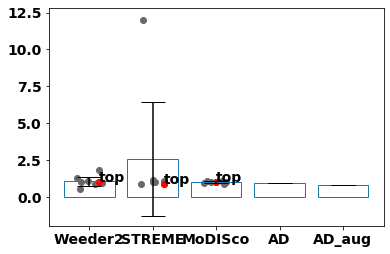

In [12]:
# Overall
results_dir = "comparison_figs/"+target+"/calibrated/"
w = 0.8    # bar width
x = [1, 2, 3, 4, 5]     # x-coordinates of bars

criteria = "rmse"
meta = {}
weeder = []
weeder_x = []
meta["best_weeder"] = 10^5
for filename in os.listdir(results_dir+"weeder/"):
    if "weeder_max_" in filename and filename.endswith("metadata.json"):
        data = json.load(open(results_dir+"weeder/"+filename))
        weeder.append(float(data[criteria]))
        weeder_x.append(1 + np.random.random() * (w/2) - (w/4))   # distribute coords randomly across half width of bar
        if weeder[-1] <= meta["best_weeder"]:
            meta["best_weeder"] = weeder[-1]
            meta["best_weeder_name"] = filename
        if filename == "weeder_max_0_metadata.json":
            top_weeder_x = weeder_x[-1]
            top_weeder_y = weeder[-1]
streme = []
streme_x = []
meta["best_streme"] = 10^5
for filename in os.listdir(results_dir+"streme/"):
    if "streme_max_" in filename and filename.endswith("metadata.json"):
        data = json.load(open(results_dir+"streme/"+filename))
        streme.append(float(data[criteria]))
        streme_x.append(2 + np.random.random() * (w/2) - (w/4))
        if streme[-1] <= meta["best_streme"]:
            meta["best_streme"] = streme[-1]
            meta["best_streme_name"] = filename
        if filename == "streme_max_0_metadata.json":
            top_streme_x = streme_x[-1]
            top_streme_y = streme[-1]
modisco = []
modisco_x = []
meta["best_modisco"] = 10^5
for filename in os.listdir(results_dir+"modisco/"):
    if "modisco_max_" in filename and filename.endswith("metadata.json"):
        data = json.load(open(results_dir+"modisco/"+filename))
        modisco.append(float(data[criteria]))
        modisco_x.append(3 + np.random.random() * (w/2) - (w/4))
        if modisco[-1] <= meta["best_modisco"]:
            meta["best_modisco"] = modisco[-1]
            meta["best_modisco_name"] = filename
        if filename == "modisco_max_0_metadata.json":
            top_modisco_x = modisco_x[-1]
            top_modisco_y = modisco[-1]
affinity_distill = []
data = json.load(open(results_dir+"affinity_distill/affinity_distill_metadata.json"))
affinity_distill.append(float(data[criteria]))
meta["affinity_distill"] = affinity_distill[0]
affinity_distill_augmented = []
data = json.load(open(results_dir+"affinity_distill_augmented/affinity_distill_augmented_metadata.json"))
affinity_distill_augmented.append(float(data[criteria]))
meta["affinity_distill_augmented"] = affinity_distill_augmented[0]

y = [weeder, streme, modisco, affinity_distill, affinity_distill_augmented]
coords_x = [weeder_x, streme_x, modisco_x]
top_x = [top_weeder_x, top_streme_x, top_modisco_x]
top_y = [top_weeder_y, top_streme_y, top_modisco_y]
fig, ax = plt.subplots()
ax.bar(x, height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["Weeder2", "STREME", "MoDISco", "AD", "AD_aug"],
       color=(0,0,0,0),  # face color transparent
       edgecolor='#1f77b4')
for i in range(len(coords_x)):
    ax.scatter(coords_x[i], y[i], color='dimgrey')
    ax.annotate("top", (top_x[i], top_y[i]))
ax.scatter(top_x, top_y, color='red')
with open(results_dir+criteria+'.json', 'w') as fp: json.dump(meta, fp)
fig.savefig(results_dir+criteria+'.png', dpi=300, format='png')

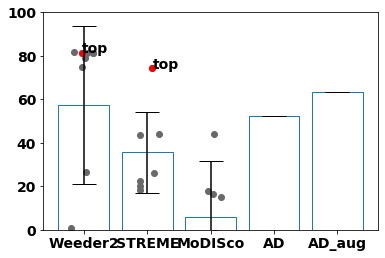

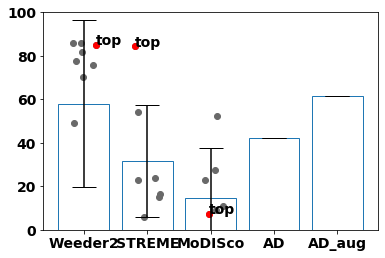

In [13]:
for criteria in ["spearman", "pearson"]:
    meta = {}
    weeder = []
    weeder_x = []
    meta["best_weeder"] = -100
    for filename in os.listdir(results_dir+"weeder/"):
        if "weeder_max_" in filename and filename.endswith("metadata.json"):
            data = json.load(open(results_dir+"weeder/"+filename))
            weeder.append(float(data[criteria])*100)
            weeder_x.append(1 + np.random.random() * (w/2) - (w/4))   # distribute coords randomly across half width of bar
            if weeder[-1] >= meta["best_weeder"]:
                meta["best_weeder"] = weeder[-1]
                meta["best_weeder_name"] = filename
            if filename == "weeder_max_0_metadata.json":
                top_weeder_x = weeder_x[-1]
                top_weeder_y = weeder[-1]
    streme = []
    streme_x = []
    meta["best_streme"] = -100
    for filename in os.listdir(results_dir+"streme/"):
        if "streme_max_" in filename and filename.endswith("metadata.json"):
            data = json.load(open(results_dir+"streme/"+filename))
            streme.append(float(data[criteria])*100)
            streme_x.append(2 + np.random.random() * (w/2) - (w/4))
            if streme[-1] >= meta["best_streme"]:
                meta["best_streme"] = streme[-1]
                meta["best_streme_name"] = filename
            if filename == "streme_max_0_metadata.json":
                top_streme_x = streme_x[-1]
                top_streme_y = streme[-1]
    modisco = []
    modisco_x = []
    meta["best_modisco"] = -100
    for filename in os.listdir(results_dir+"modisco/"):
        if "modisco_max_" in filename and filename.endswith("metadata.json"):
            data = json.load(open(results_dir+"modisco/"+filename))
            modisco.append(float(data[criteria])*100)
            modisco_x.append(3 + np.random.random() * (w/2) - (w/4))
            if modisco[-1] >= meta["best_modisco"]:
                meta["best_modisco"] = modisco[-1]
                meta["best_modisco_name"] = filename
            if filename == "modisco_max_0_metadata.json":
                top_modisco_x = modisco_x[-1]
                top_modisco_y = modisco[-1]
    affinity_distill = []
    data = json.load(open(results_dir+"affinity_distill/affinity_distill_metadata.json"))
    affinity_distill.append(float(data[criteria])*100)
    meta["affinity_distill"] = affinity_distill[0]
    affinity_distill_augmented = []
    data = json.load(open(results_dir+"affinity_distill_augmented/affinity_distill_augmented_metadata.json"))
    affinity_distill_augmented.append(float(data[criteria])*100)
    meta["affinity_distill_augmented"] = affinity_distill_augmented[0]

    y = [weeder, streme, modisco, affinity_distill, affinity_distill_augmented]
    coords_x = [weeder_x, streme_x, modisco_x]
    top_x = [top_weeder_x, top_streme_x, top_modisco_x]
    top_y = [top_weeder_y, top_streme_y, top_modisco_y]
    fig, ax = plt.subplots()
    ax.bar(x,
           height=[np.mean(yi) for yi in y],
           yerr=[np.std(yi) for yi in y],    # error bars
           capsize=12, # error bar cap width in points
           width=w,    # bar width
           tick_label=["Weeder2", "STREME", "MoDISco", "AD", "AD_aug"],
           color=(0,0,0,0),  # face color transparent
           edgecolor='#1f77b4')
    for i in range(len(coords_x)):
        ax.scatter(coords_x[i], y[i], color='dimgrey')
        ax.annotate("top", (top_x[i], top_y[i]))
    ax.set_ylim([0, 100])
    ax.scatter(top_x, top_y, color='red')
    with open(results_dir+criteria+'.json', 'w') as fp: json.dump(meta, fp)
    fig.savefig(results_dir+criteria+'.png', dpi=300, format='png')

## Dynamic range of standard model (before augmentation)

In [14]:
bins = np.linspace(np.min(all_xvals), np.max(all_xvals), 20)
sample_preds = []
for seq in calibration_samples:
    sample_preds.append(float(seqToDeltaLogCounts[seq]))
sample_preds = np.array(sample_preds)
pre_yvals = []
for seq in seqs:
    pre_yvals.append(float(seqToDeltaLogCounts[seq]))
pre_yvals = np.array(pre_yvals)
lr1 = LinearRegression()
calibration_func1 = lr1(sample_preds, sample_labels)
ad = calibration_func1(pre_yvals)
yvals = ad

metadata = {}
metadata["Obs. mean"] = np.mean(all_xvals)
metadata["Obs. stddev"] = np.std(all_xvals)
metadata["Pred. mean"] = np.mean(yvals)
metadata["Pred. stddev"] = np.std(yvals)
plt.figure()
matplotlib.rc('font', **font)
plt.hist(all_xvals, bins, alpha=0.5, density=True, label='Observed')
plt.hist(yvals, bins, alpha=0.5, density=True, label='Predicted')
plt.legend()
plt.title("AD Standard")
plt.savefig(results_dir+'standard_dynamic_range.png', dpi=300, format='png')
with open(results_dir+'standard_dynamic_range_metadata.json', 'w') as fp: json.dump(metadata, fp)
plt.clf()

<Figure size 432x288 with 0 Axes>

## Dynamic range of augmented model

In [15]:
bins = np.linspace(np.min(all_xvals), np.max(all_xvals), 50)
sample_preds = []
for seq in calibration_samples:
    sample_preds.append(float(seqToDeltaLogCounts_augmented[seq]))
sample_preds = np.array(sample_preds)
pre_yvals = []
for seq in seqs:
    pre_yvals.append(float(seqToDeltaLogCounts_augmented[seq]))
pre_yvals = np.array(pre_yvals)
lr1 = LinearRegression()
calibration_func1 = lr1(sample_preds, sample_labels)
ad_aug = calibration_func1(pre_yvals)
yvals = ad_aug

metadata = {}
metadata["Obs. mean"] = np.mean(all_xvals)
metadata["Obs. stddev"] = np.std(all_xvals)
metadata["Pred. mean"] = np.mean(yvals)
metadata["Pred. stddev"] = np.std(yvals)
plt.figure()
matplotlib.rc('font', **font)
plt.hist(all_xvals, bins, alpha=0.5, density=True, label='Observed')
plt.hist(yvals, bins, alpha=0.5, density=True, label='Predicted')
plt.legend()
plt.title("AD Augmented")
plt.savefig(results_dir+'augmented_dynamic_range.png', dpi=300, format='png')
with open(results_dir+'augmented_dynamic_range_metadata.json', 'w') as fp: json.dump(metadata, fp)
plt.clf()

<Figure size 432x288 with 0 Axes>

## overall

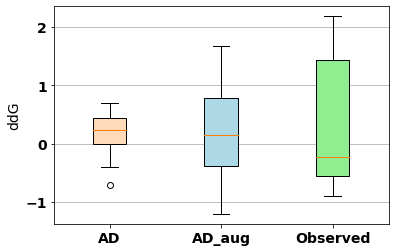

In [16]:
data = [ad, ad_aug, all_xvals]
labels = ['AD', 'AD_aug', 'Observed']
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
bplot = ax.boxplot(data, patch_artist=True, labels=labels)
colors = ['peachpuff', 'lightblue', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
ax.yaxis.grid(True)
ax.set_ylabel("ddG")
plt.savefig(results_dir+'overall.png', dpi=300, format='png')

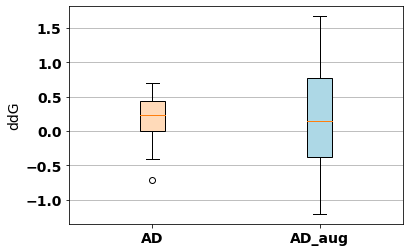

In [17]:
data = [ad, ad_aug]
labels = ['AD', 'AD_aug']
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
bplot = ax.boxplot(data, patch_artist=True, labels=labels)
colors = ['peachpuff', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
ax.yaxis.grid(True)
ax.set_ylabel("ddG")
plt.savefig(results_dir+'dr_diff.png', dpi=300, format='png')